In [40]:
import tempfile

import numpy as np
import open_clip
import torch as T
import urllib.request
from PIL import Image

import segmentation.xai as xai

In [2]:
model_name, model_weights_name = 'convnext_base', 'laion400m_s13b_b51k'
model, _, preprocessor = open_clip.create_model_and_transforms(model_name, pretrained=model_weights_name)
model = model.cuda().eval()  # type: ignore

tokenizer = open_clip.get_tokenizer(model_name)

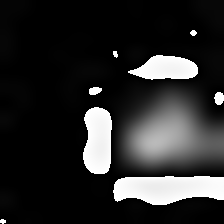

In [42]:
with tempfile.NamedTemporaryFile(suffix='.jpg') as f:
    image_path = f.name
    image_url = "https://static.toiimg.com/photo/79693966.cms"
    urllib.request.urlretrieve(image_url, image_path)
    image = Image.open(image_path).convert('RGB')

xai_method = xai.LayerCam(
    layers_extractor=lambda model: model.trunk.stages,
    layers_selector=lambda layers: layers[-2:],
    # layers_selector=lambda layers: [layers[-2]],
)

texts = ['french fries']
tokenized_text = tokenizer(texts)
with T.no_grad(), T.cuda.amp.autocast():  # type: ignore
    text_features = model.encode_text(tokenized_text.cuda())  # type: ignore

text_feature = text_features[0].unsqueeze(0)

img_tensor = preprocessor(image).unsqueeze(0).cuda()
att_map = xai_method(model.visual, img_tensor, text_feature)

att_map_np = att_map[0].cpu().detach().squeeze().numpy()
att_map_np.shape
att_img = Image.fromarray((att_map_np * 255).astype(np.uint8))

att_img

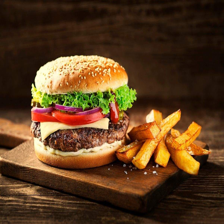

In [25]:
image.resize((224, 224))